# Eating out in Lyon - Data analysis

## Summary

This is the second part of a data analysis project focused on finding a delicious pizza in my hometown of Lyon.
After gathering and cleaning data in the first part, I now focus on data analysis.
In the exploratory data analysis, I focus mainly on the mean price and ratings of restaurants accross city districts and restaurant categories. I then go looking for outstanding restaurants, - _i.e._, restaurants with a higher rating than restaurants of the same category and district - using the residuals of an linear model.

## Findings

Geographical analysis:
    - The historical center (Lyon 1 and 2) has the most restaurants, as well as the most reviews which makes sense given its touristic appeal.
    - Restaurants in fancy neighbourhoods (Lyon 5 and 6) are the most expensive on average, but this is not reflected by higher ratings.
    - Restaurants have better ratings on average in Lyon 7.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/restaurants.csv')

In [3]:
data[data.columns[:8]].head()

,id,alias,name,review_count,rating,price,coordinates.latitude,coordinates.longitude
0,D3NHTerar80aeR6mlyE2mw,azur-afghan-lyon,Azur Afghan,23,4.0,€€,45.775020,4.828750
1,ee4wtKIBI_yTz0fJD054pg,tendance-afghane-lyon,Tendance Afghane,1,3.0,NaN,45.759540,4.825560
2,zmk41IUwIkvO_eM0UGD7Sg,sufy-lyon,Sufy,2,3.5,NaN,45.752212,4.864384
3,Vo0U5EcXbh7qlpdaQwZchA,le-conakry-lyon,Le Conakry,9,4.0,€€,45.750642,4.849127
4,-mFHJBuCxZJ_wJrO-o2Ypw,afc-africa-food-concept-lyon,AFC Africa Food Concept,8,3.5,€€,45.754336,4.843469


In [4]:
data[data.columns[8:]].head()

,location.address1,location.address2,location.address3,location.zip_code,location.country,location.display_address
0,6 Rue Villeneuve,NaN,NaN,69004,FR,"['6 Rue Villeneuve', '69004 Lyon', 'France']"
1,25 Rue Tramassac,NaN,NaN,69005,FR,"['25 Rue Tramassac', '69005 Lyon', 'France']"
2,34 rue Jeanne Hachette,NaN,NaN,69003,FR,"['34 rue Jeanne Hachette', '69003 Lyon', 'Fran..."
3,112 Grande rue de la Guillotière,NaN,NaN,69007,FR,"['112 Grande rue de la Guillotière', '69007 Ly..."
4,14 Grande rue de la Guillotière,NaN,NaN,69007,FR,"['14 Grande rue de la Guillotière', '69007 Lyo..."


In [5]:
data['price_num'] = data['price'].map({'€': 1, '€€': 2, '€€€': 3, '€€€€': 4})

<AxesSubplot:xlabel='rating', ylabel='count'>

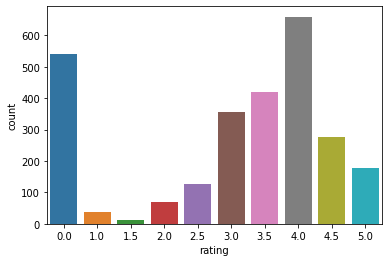

In [6]:
sns.countplot(data = data, x = "rating")

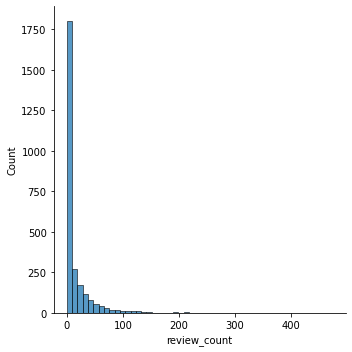

In [7]:
sns.displot(data = data, x = "review_count", bins = 50)

In [8]:
data = data[data['review_count'] >= 10]

<AxesSubplot:xlabel='rating', ylabel='count'>

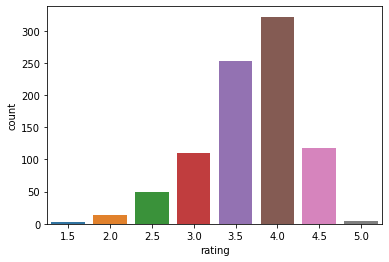

In [9]:
sns.countplot(data = data, x = "rating")

<AxesSubplot:xlabel='location.zip_code', ylabel='rating'>

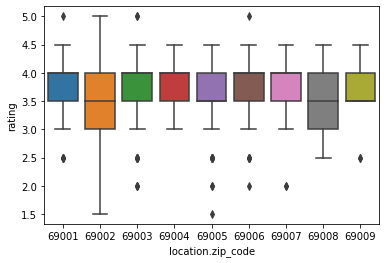

In [10]:
sns.boxplot(data = data, x = 'location.zip_code', y = 'rating')

In [11]:
import geopandas
import geodatasets
import contextily as cx
from shapely.geometry import Point

In [12]:
lyon_map = geopandas.read_file('data/adr_voie_lieu.adrarrond.geojson')
lyon_map

,nom,nomreduit,insee,datemaj,trigramme,gid,geometry
0,Lyon 1er Arrondissement,Lyon 1,69381,1997-10-22 00:00:00+00:00,LY1,128,"POLYGON ((4.83049 45.76454, 4.83125 45.76484, ..."
1,Lyon 9e Arrondissement,Lyon 9,69389,2005-07-19 00:00:00+00:00,LY9,181,"POLYGON ((4.81088 45.78099, 4.81145 45.78177, ..."
2,Lyon 2e Arrondissement,Lyon 2,69382,1997-10-22 00:00:00+00:00,LY2,59,"POLYGON ((4.81782 45.72649, 4.81868 45.72660, ..."
3,Lyon 4e Arrondissement,Lyon 4,69384,2003-05-12 00:00:00+00:00,LY4,29,"POLYGON ((4.81856 45.78944, 4.81817 45.78914, ..."
4,Lyon 3e Arrondissement,Lyon 3,69383,2005-07-19 00:00:00+00:00,LY3,125,"POLYGON ((4.83901 45.75660, 4.83956 45.75643, ..."
5,Lyon 5e Arrondissement,Lyon 5,69385,2005-07-19 00:00:00+00:00,LY5,53,"POLYGON ((4.81353 45.74819, 4.81357 45.74823, ..."
6,Lyon 7e Arrondissement,Lyon 7,69387,2000-03-30 00:00:00+00:00,LY7,189,"POLYGON ((4.83770 45.70737, 4.83894 45.70763, ..."
7,Lyon 8e Arrondissement,Lyon 8,69388,2011-03-03 00:00:00+00:00,LY8,42,"POLYGON ((4.84879 45.71885, 4.84881 45.71879, ..."
8,Lyon 6e Arrondissement,Lyon 6,69386,2005-07-19 00:00:00+00:00,LY6,45,"POLYGON ((4.86994 45.76373, 4.86986 45.76384, ..."


In [13]:
lyon_map['location.zip_code'] = lyon_map['nomreduit'].apply(lambda x:('6900' + x[-1])).astype('int')
lyon_map

,nom,nomreduit,insee,datemaj,trigramme,gid,geometry,location.zip_code
0,Lyon 1er Arrondissement,Lyon 1,69381,1997-10-22 00:00:00+00:00,LY1,128,"POLYGON ((4.83049 45.76454, 4.83125 45.76484, ...",69001
1,Lyon 9e Arrondissement,Lyon 9,69389,2005-07-19 00:00:00+00:00,LY9,181,"POLYGON ((4.81088 45.78099, 4.81145 45.78177, ...",69009
2,Lyon 2e Arrondissement,Lyon 2,69382,1997-10-22 00:00:00+00:00,LY2,59,"POLYGON ((4.81782 45.72649, 4.81868 45.72660, ...",69002
3,Lyon 4e Arrondissement,Lyon 4,69384,2003-05-12 00:00:00+00:00,LY4,29,"POLYGON ((4.81856 45.78944, 4.81817 45.78914, ...",69004
4,Lyon 3e Arrondissement,Lyon 3,69383,2005-07-19 00:00:00+00:00,LY3,125,"POLYGON ((4.83901 45.75660, 4.83956 45.75643, ...",69003
5,Lyon 5e Arrondissement,Lyon 5,69385,2005-07-19 00:00:00+00:00,LY5,53,"POLYGON ((4.81353 45.74819, 4.81357 45.74823, ...",69005
6,Lyon 7e Arrondissement,Lyon 7,69387,2000-03-30 00:00:00+00:00,LY7,189,"POLYGON ((4.83770 45.70737, 4.83894 45.70763, ...",69007
7,Lyon 8e Arrondissement,Lyon 8,69388,2011-03-03 00:00:00+00:00,LY8,42,"POLYGON ((4.84879 45.71885, 4.84881 45.71879, ...",69008
8,Lyon 6e Arrondissement,Lyon 6,69386,2005-07-19 00:00:00+00:00,LY6,45,"POLYGON ((4.86994 45.76373, 4.86986 45.76384, ...",69006


In [14]:
lyon_map = lyon_map.merge(
                data.groupby('location.zip_code')[['review_count', 'rating', 'price_num']].agg([np.mean, np.median]),
                on = 'location.zip_code',
                how = 'left')

lyon_map = lyon_map.merge(
                data.groupby('location.zip_code')['id'].count().reset_index(name="restaurants_count"),
                on = 'location.zip_code',
                how = 'left')

/home/camille/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1569: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = DataFrame.merge(self, *args, **kwargs)


In [15]:
lyon_map = lyon_map.to_crs(epsg = 3857)

In [16]:
lyon_map

,nom,nomreduit,insee,datemaj,trigramme,gid,geometry,location.zip_code,"(review_count, mean)","(review_count, median)","(rating, mean)","(rating, median)","(price_num, mean)","(price_num, median)",restaurants_count
0,Lyon 1er Arrondissement,Lyon 1,69381,1997-10-22 00:00:00+00:00,LY1,128,"POLYGON ((537728.157 5742697.193, 537812.142 5...",69001,48.586667,33.5,3.800000,4.0,2.233333,2.0,150
1,Lyon 9e Arrondissement,Lyon 9,69389,2005-07-19 00:00:00+00:00,LY9,181,"POLYGON ((535544.690 5745322.184, 535608.442 5...",69009,34.380952,19.0,3.690476,3.5,2.333333,2.0,21
2,Lyon 2e Arrondissement,Lyon 2,69382,1997-10-22 00:00:00+00:00,LY2,59,"POLYGON ((536317.379 5736627.156, 536413.158 5...",69002,47.790698,33.0,3.511628,3.5,2.214286,2.0,215
3,Lyon 4e Arrondissement,Lyon 4,69384,2003-05-12 00:00:00+00:00,LY4,29,"POLYGON ((536400.153 5746670.330, 536355.755 5...",69004,32.641026,23.0,3.769231,4.0,2.289474,2.0,39
4,Lyon 3e Arrondissement,Lyon 3,69383,2005-07-19 00:00:00+00:00,LY3,125,"POLYGON ((538675.908 5741429.308, 538737.755 5...",69003,30.625000,19.5,3.696429,4.0,2.234234,2.0,112
5,Lyon 5e Arrondissement,Lyon 5,69385,2005-07-19 00:00:00+00:00,LY5,53,"POLYGON ((535840.241 5740088.703, 535843.663 5...",69005,37.029412,31.0,3.602941,3.5,2.410000,2.0,102
6,Lyon 7e Arrondissement,Lyon 7,69387,2000-03-30 00:00:00+00:00,LY7,189,"POLYGON ((538529.869 5733577.714, 538667.968 5...",69007,39.952381,26.0,3.866667,4.0,2.200000,2.0,105
7,Lyon 8e Arrondissement,Lyon 8,69388,2011-03-03 00:00:00+00:00,LY8,42,"POLYGON ((539764.302 5735407.901, 539767.383 5...",69008,32.120000,20.0,3.520000,3.5,1.960000,2.0,25
8,Lyon 6e Arrondissement,Lyon 6,69386,2005-07-19 00:00:00+00:00,LY6,45,"POLYGON ((542119.679 5742567.380, 542109.793 5...",69006,29.745283,23.0,3.698113,4.0,2.424528,2.0,106


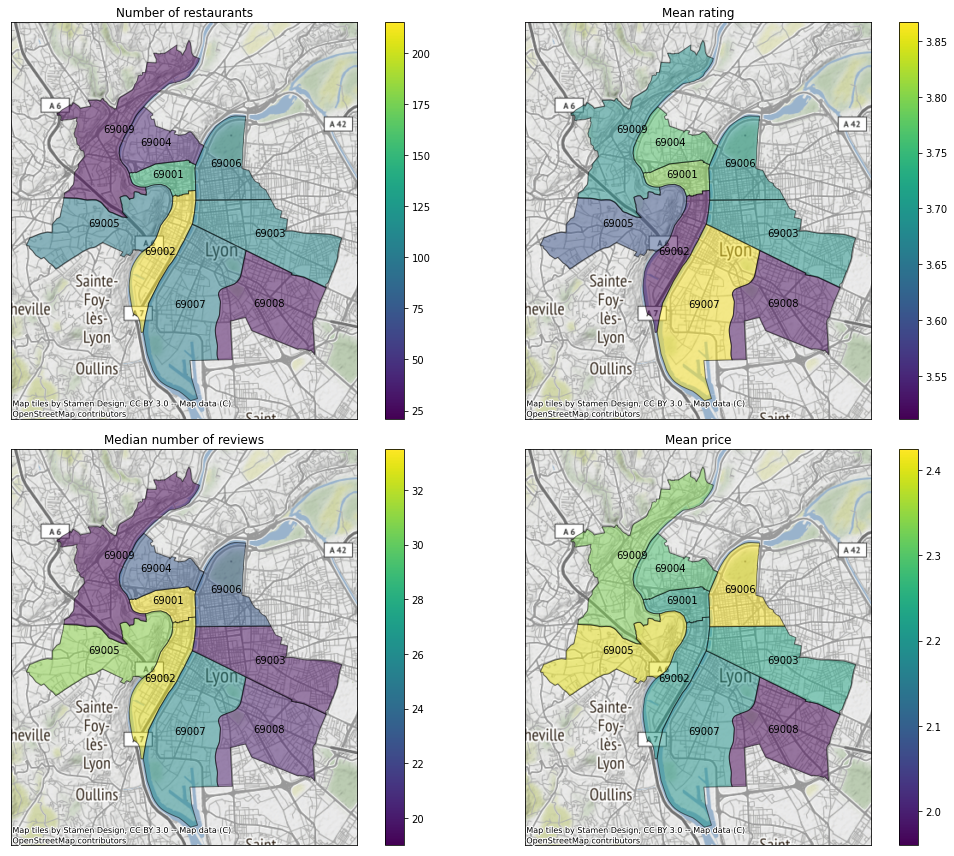

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (15, 12))

# plotting number of restaurants
lyon_map.plot(ax = ax[0, 0], alpha = 0.5, edgecolor = "k", column = 'restaurants_count', legend = True)
lyon_map.apply(lambda x: ax[0, 0].annotate(text=x['location.zip_code'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center'), axis=1)
cx.add_basemap(ax[0, 0], zoom = 12)
ax[0, 0].set_title('Number of restaurants')


# plotting mean rating
lyon_map.plot(ax = ax[0, 1],alpha = 0.5, edgecolor = "k",
                   column = ('rating', 'mean'), legend = True)
lyon_map.apply(lambda x: ax[0, 1].annotate(text=x['location.zip_code'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center'), axis=1)
cx.add_basemap(ax[0, 1], zoom = 12)
ax[0, 1].set_title('Mean rating')

# plotting median review count
lyon_map.plot(ax = ax[1, 0], alpha = 0.5, edgecolor = "k", column = ('review_count', 'median'), legend = True)
lyon_map.apply(lambda x: ax[1, 0].annotate(text=x['location.zip_code'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center'), axis=1)
cx.add_basemap(ax[1, 0], zoom = 12)
ax[1, 0].set_title('Median number of reviews')

# plotting mean price
lyon_map.plot(ax = ax[1, 1], alpha = 0.5, edgecolor = "k", column = ('price_num', 'mean'), legend = True)
lyon_map.apply(lambda x: ax[1, 1].annotate(text=x['location.zip_code'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center'), axis=1)
cx.add_basemap(ax[1, 1], zoom = 12)
ax[1, 1].set_title('Mean price')

# removing ticks for better visibility
for k in [0, 1]:
    for l in [0, 1]:
        ax[k, l].set_xticks([])
        ax[l, k].set_yticks([])
        
fig.tight_layout()

## Ratings by category

In [18]:
categories_df = pd.read_csv('data/categories.csv')

<AxesSubplot:ylabel='Count'>

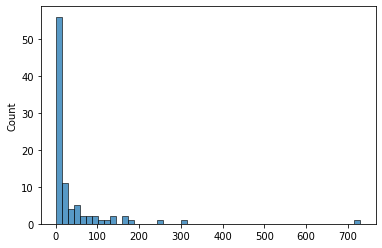

In [19]:
sns.histplot(categories_df.drop('id', axis = 1).sum())

In [20]:
categories_df.drop('id', axis = 1).sum().sort_values(ascending = False)[:25]

french              730.0
hotdogs             308.0
pizza               255.0
italian             174.0
sandwiches          164.0
cafes               159.0
bistros             139.0
brasseries          134.0
burgers             123.0
japanese            113.0
lyonnais            100.0
salad                87.0
sushi                79.0
breakfast_brunch     75.0
tapas                65.0
tapasmallplates      59.0
panasian             54.0
kebab                52.0
indpak               51.0
creperies            50.0
chinese              49.0
vietnamese           41.0
seafood              36.0
halal                35.0
mediterranean        30.0
dtype: float64

In [21]:
## dropping all categories concerning less than 100 restaurants
sorted_categories = categories_df.drop('id', axis = 1).sum().sort_values(ascending = False)
top_categories = sorted_categories[sorted_categories >= 100]
non_top_categories = sorted_categories[sorted_categories < 100]
top_categories

french        730.0
hotdogs       308.0
pizza         255.0
italian       174.0
sandwiches    164.0
cafes         159.0
bistros       139.0
brasseries    134.0
burgers       123.0
japanese      113.0
lyonnais      100.0
dtype: float64

In [22]:
categories_df.drop(non_top_categories.index, axis = 1, inplace = True)

In [23]:
categories_df.head()

,id,french,burgers,hotdogs,pizza,brasseries,sandwiches,cafes,japanese,bistros,lyonnais,italian
0,D3NHTerar80aeR6mlyE2mw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ee4wtKIBI_yTz0fJD054pg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,zmk41IUwIkvO_eM0UGD7Sg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Vo0U5EcXbh7qlpdaQwZchA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-mFHJBuCxZJ_wJrO-o2Ypw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### mean prices by categories

In [24]:
top_categories = pd.DataFrame(top_categories)
top_categories.reset_index(inplace = True)
top_categories.columns = ['alias', 'count']

In [25]:
top_categories

,alias,count
0,french,730.0
1,hotdogs,308.0
2,pizza,255.0
3,italian,174.0
4,sandwiches,164.0
5,cafes,159.0
6,bistros,139.0
7,brasseries,134.0
8,burgers,123.0
9,japanese,113.0


In [26]:
top_categories["mean_rating"] = top_categories['alias'].apply(lambda x: data['rating'][categories_df[x] > 0].mean())

top_categories["median_reviews"] = top_categories['alias'].apply(lambda x: data['review_count'][categories_df[x] > 0].median())

top_categories["mean_price"] = top_categories['alias'].apply(lambda x: data['price_num'][categories_df[x] > 0].mean())



In [27]:
top_categories

,alias,count,mean_rating,median_reviews,mean_price
0,french,730.0,3.747368,30.0,2.553571
1,hotdogs,308.0,3.366667,19.0,1.750000
2,pizza,255.0,3.561404,20.0,2.017544
3,italian,174.0,3.571429,20.5,2.115942
4,sandwiches,164.0,3.557692,20.0,1.576923
5,cafes,159.0,3.833333,30.0,1.974359
6,bistros,139.0,3.957143,24.0,2.314286
7,brasseries,134.0,3.346154,28.0,2.435897
8,burgers,123.0,3.337209,34.0,1.906977
9,japanese,113.0,3.661017,31.0,2.237288


<AxesSubplot:xlabel='count', ylabel='alias'>

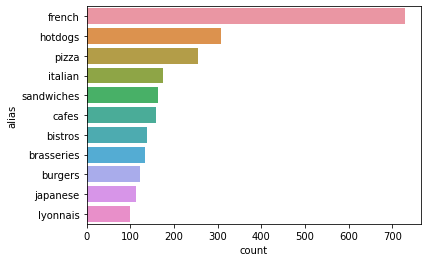

In [28]:
sns.barplot(data = top_categories, x = 'count', y = 'alias')

<AxesSubplot:xlabel='mean_rating', ylabel='alias'>

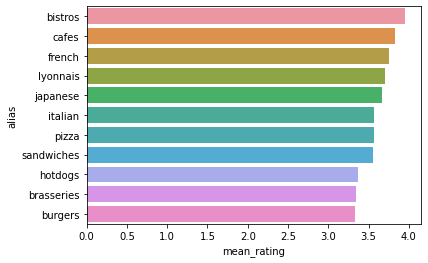

In [29]:
sns.barplot(data = top_categories, x = 'mean_rating', y = 'alias',
            order = top_categories.sort_values('mean_rating', ascending = False).alias)

<AxesSubplot:xlabel='median_reviews', ylabel='alias'>

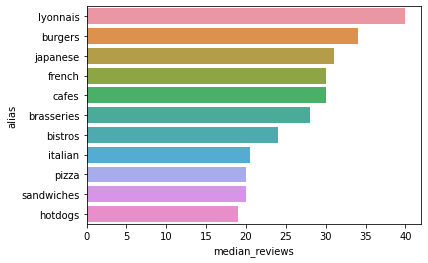

In [30]:
sns.barplot(data = top_categories, x = 'median_reviews', y = 'alias',
            order = top_categories.sort_values('median_reviews', ascending = False).alias)

<AxesSubplot:xlabel='mean_price', ylabel='alias'>

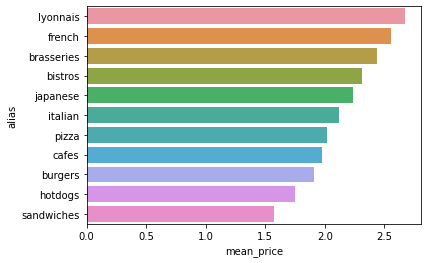

In [31]:
sns.barplot(data = top_categories, x = 'mean_price', y = 'alias',
            order = top_categories.sort_values('mean_price', ascending = False).alias)

## Finding the best pizza in town

I now want to identify "good" restaurants, _i.e._, restaurants that are better rated than restaurants in the same category, neighboorhoud and price range. To do so, let us fit a simple linear model that predicts rating from the zip code, categories and price of a restaurant.

In [32]:
from sklearn.linear_model import LinearRegression

y = data['rating']
X = data[['id', 'location.zip_code']].merge(categories_df, how = 'left', on = 'id')
X = pd.concat([X, pd.get_dummies(data['price']).reset_index()], axis = 1).drop(['id', 'index'], axis = 1)
X = X.values

lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

In [33]:
data['predicted_rating'] = lm.predict(X)
data['residual'] = data['rating'] - data['predicted_rating']

(2.9275765540495455, 4.199776507454777, 1.325, 5.175)

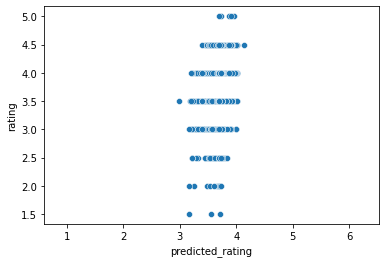

In [34]:
sns.scatterplot(data = data, x = 'predicted_rating', y = 'rating')
plt.axis('equal')

<AxesSubplot:xlabel='predicted_rating', ylabel='residual'>

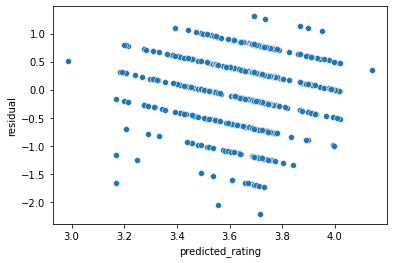

In [35]:
sns.scatterplot(data = data, x = 'predicted_rating', y = 'residual')

In [36]:
best_pizza = data.loc[data[categories_df["pizza"] == 1].groupby('location.zip_code')['residual'].idxmax()]
best_pizza

/tmp/ipykernel_429332/1230064884.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_pizza = data.loc[data[categories_df["pizza"] == 1].groupby('location.zip_code')['residual'].idxmax()]


,id,alias,name,review_count,rating,price,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.zip_code,location.country,location.display_address,price_num,predicted_rating,residual
2262,PuoXHghTfTjHV9LNG10QCA,le-jardin-des-pentes-lyon-2,Le Jardin des Pentes,23,4.0,€,45.771235,4.828179,20 Montée des Carmélites,NaN,NaN,69001,FR,"['20 Montée des Carmélites', '69001 Lyon', 'Fr...",1.0,3.552320,0.447680
1773,6_KiiZvgX4f2dEy5OYDxCg,casa-nobile-lyon,Casa Nobile,103,4.5,€€,45.759080,4.835950,3 place de l'Hopital,NaN,NaN,69002,FR,"[""3 place de l'Hopital"", '69002 Lyon', 'France']",2.0,3.512696,0.987304
1823,snO_r0d0iAS_FY9jQHD6nA,le-ferrari-lyon,Le Ferrari,13,4.5,€€€,45.752879,4.895057,162 cours du Docteur Long,NaN,NaN,69003,FR,"['162 cours du Docteur Long', '69003 Lyon', 'F...",3.0,3.542236,0.957764
2274,_vt2LLpwJdTWCmpNurW93w,chez-puce-lyon,Chez Puce,50,4.5,€€,45.779850,4.835200,5 place du Commandant Arnaud,NaN,NaN,69004,FR,"['5 place du Commandant Arnaud', '69004 Lyon',...",2.0,3.617033,0.882967
1804,j17WWFmYW5zMjJuwtOtgiQ,al-dente-lyon,Al Dente,12,4.0,€€,45.759680,4.825590,54 rue Tramassac,NaN,NaN,69005,FR,"['54 rue Tramassac', '69005 Lyon', 'France']",2.0,3.536905,0.463095
1786,qbjWAbwerA7YLOBBeBNHqQ,neroliva-lyon,Neroliva,15,4.5,€€,45.764530,4.853870,13 rue Juliette Recamier,NaN,NaN,69006,FR,"['13 rue Juliette Recamier', '69006 Lyon', 'Fr...",2.0,3.544974,0.955026
1790,gqYt2KV8podyMuMp6WudWg,le-vivaldi-nicolo-e-maria-lyon,Le Vivaldi - Nicolo e Maria,44,4.5,€€,45.745937,4.840151,49 ave Berthelot,NaN,NaN,69007,FR,"['49 ave Berthelot', '69007 Lyon', 'France']",2.0,3.553044,0.946956
2282,tBZWMHeDwS27bDXnrdkMmw,pizza-lina-lyon-2,Pizza Lina,10,4.0,€€,45.744560,4.868290,8 Rue St Maurice,NaN,NaN,69008,FR,"['8 Rue St Maurice', '69008 Lyon', 'France']",2.0,3.649311,0.350689
1808,YG3xIW4i8V3zLIDDxhz2UQ,domeva-caffé-lyon-2,Domeva Caffé,34,4.5,€€,45.776790,4.804170,24 rue de Bourgogne,NaN,NaN,69009,FR,"['24 rue de Bourgogne', '69009 Lyon', 'France']",2.0,3.569183,0.930817


<AxesSubplot:xlabel='coordinates.latitude', ylabel='coordinates.longitude'>

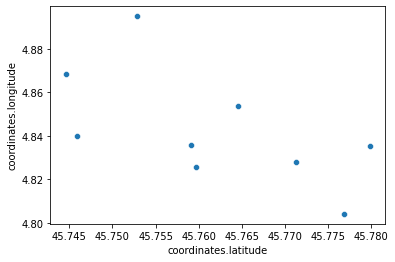

In [37]:
sns.scatterplot(data = best_pizza, x = 'coordinates.latitude', y = 'coordinates.longitude')

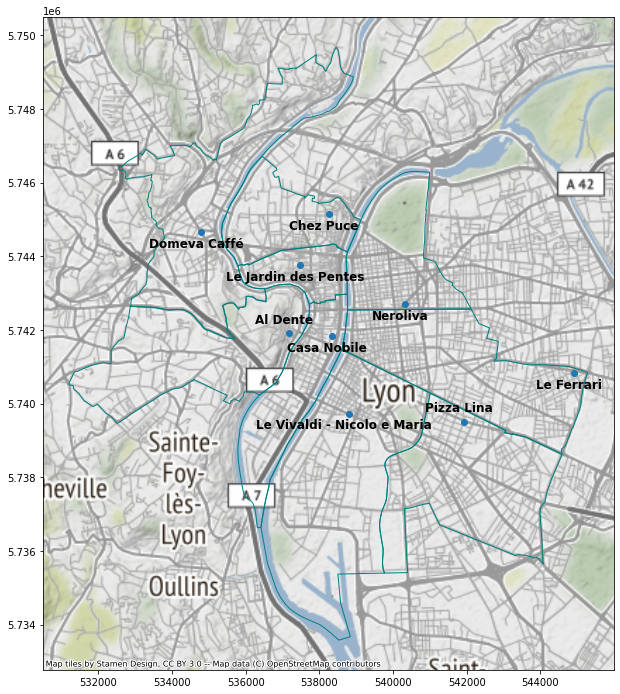

In [139]:
best_pizza = geopandas.GeoDataFrame(
    best_pizza,
    geometry = geopandas.points_from_xy(best_pizza['coordinates.longitude'], best_pizza['coordinates.latitude'],
    crs = 'EPSG:4326')
)
best_pizza.to_crs(str(lyon_map.crs), inplace = True)


ax = lyon_map.plot(edgecolor = "teal", facecolor = 'none', figsize=(12, 12))
best_pizza.plot(ax = ax)
best_pizza.apply(lambda x: ax.annotate(text=x['name'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center',
                                     xytext=(-5, 10) if x['location.zip_code'] in [69005, 69008] else (-5, -15),
                                     textcoords="offset points",
                                     weight = 'bold',
                                     fontsize = 12), axis=1)

cx.add_basemap(ax, zoom = 12, crs = best_pizza.crs)

In [136]:
best_pizza['location.zip_code']

2262    69001
1773    69002
1823    69003
2274    69004
1804    69005
1786    69006
1790    69007
2282    69008
1808    69009
Name: location.zip_code, dtype: int64